In [18]:

from langgraph.graph import MessagesState
from typing import Literal
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_chroma import Chroma
from langchain.tools.retriever import create_retriever_tool
from langchain.chains.query_constructor.base import AttributeInfo
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
import os
import ast


os.environ["AZURE_OPENAI_API_KEY"]="6d440529fad24ffc8aef6d5f9ef52593"
os.environ["AZURE_OPENAI_ENDPOINT"]="https://aiall9596864698.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview"
os.environ["ALPHAVANTAGE_API_KEY"]="5TW2G5K4N9GKMGRD"

In [2]:
embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    azure_endpoint='https://aiall9596864698.cognitiveservices.azure.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2023-05-15',
    api_key='6d440529fad24ffc8aef6d5f9ef52593',
    openai_api_version="2024-07-01-preview"
)

In [3]:
class AgentState(MessagesState):
    next: str

In [ ]:
###JUNK
AttributeInfo(
                name="date",
                description="The date of 10-k filing",
                type="string or list[string]",
            ),
            
            AttributeInfo(
                name="section",
                description="The section of the 10-k filing",
                type="string or list[string]",
            ),

In [4]:
class ChromaRetrieverTool:
    def __init__(self, directory, collection, embedding, llm):
        self.directory = directory
        self.collection = collection
        self.embedding = embedding
        self.llm = llm

    def initiate_retriever(self):
        metadata_field_info = [
            
            AttributeInfo(
                name="company",
                description="The name of the company",
                type="string or list[string]",
            ),
            ]
        
        document_content_description = "Chunked content of the 10-k filing"

        self.vector_store = Chroma(
            collection_name=self.collection,
            persist_directory=self.directory,
            embedding_function=self.embedding
        )

        self.retriever=SelfQueryRetriever.from_llm(
            self.llm,
            self.vector_store,
            document_content_description,
            metadata_field_info,
            verbose=True
        )

        self.retriever_tool=create_retriever_tool(
            self.retriever,
            '10-k document retriever',
            'Query a retriever to get 10-k document information',
        )

In [5]:
members = ["tenk_expert", "financial_news"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. Remember your options are {options}. Respond only with the following JSON: ```{{'next':'option'}}```"
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    api_version="2024-08-01-preview",  # or your api version
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    )



def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    result = llm.invoke(messages)
    next_node=ast.literal_eval(result.content)['next']
    response={"next":next_node}
    return response

In [76]:

chroma_retriever = ChromaRetrieverTool(directory="../data/chroma_langchain_db_test", collection="test_collection", embedding=embeddings, llm=llm)
chroma_retriever.initiate_retriever()

from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = chroma_retriever.retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


tenk_agent = create_react_agent(
    llm, tools=[retrieve], state_modifier="You are a retrieval agent for Ten K financial reports."
)

def tenk_node(state: AgentState) -> AgentState:
    result = tenk_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="tenk_expert")
        ]
    }

yahoo_news_agent = create_react_agent(llm, tools=[retrieve], state_modifier="You are a news agent for Yahoo Finance.")

def yahoo_node(state: AgentState) -> AgentState:
    result = yahoo_news_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="financial_news")]
    }




builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("tenk_expert", tenk_node)
builder.add_node("financial_news", yahoo_node)


In [77]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

graph = builder.compile()

In [78]:
from IPython.display import display, Image


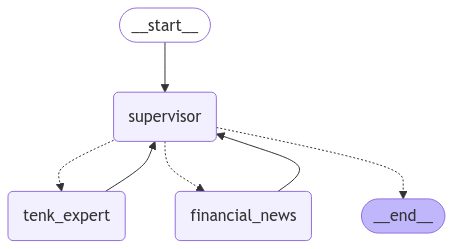

In [79]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [80]:
for s in graph.stream(
    {"messages": [("user", "How is HUBS doing for risk")]}
):
    print(s)
    print("----")

{'supervisor': {'next': 'tenk_expert'}}
----
{'tenk_expert': {'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, name='tenk_expert', id='6593bb51-8191-4c1c-963a-119d2ef8eb44')]}}
----


SyntaxError: invalid syntax (<unknown>, line 1)

In [60]:
def run_query(myquery):
    final_state=graph.invoke(
            {"messages": [HumanMessage(content=myquery)]},
            {"recursion_limit": 100},
            #return_intermediate_steps=True,
        )
    
    system_prompt_one='You are a special agent who has the key purpose of inspecting a conversation and answering the original user query given the conversation.'
    # Create the initial list
    initial_messages = [
        ("system", system_prompt_one)
    ]
    
    initial_messages.extend(final_state['messages'])
    final=llm.invoke(initial_messages)
    return final

In [61]:
myquery="I want to know about the financial news"

In [62]:
run_query(myquery)

OutputParserException: Function Router arguments:

const Router: functions.Router = ({ next }) => {
  if (next === "tenk_expert") {
    return "financial_news";
  } else {
    return "FINISH";
  }
}

are not valid JSON. Received JSONDecodeError Expecting value: line 1 column 1 (char 0)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 